#### Imports

In [1]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from cython import *
from sympy import lambdify
import sympy as sp
import copy
import functools

In [2]:
class Empty(object):
    def __init__(self):
        pass

In [3]:
class Model:
    "base class with nice init function"
    default = Empty()
    class_params = []
    
    def update_or_copy(obj, kvargs, params, just_update = False):
        for pk in params:
            if not just_update and pk in obj.default.__dict__:
                obj.__dict__[pk] = copy.copy(obj.default.__dict__[pk])
            if pk in kvargs and not kvargs[pk] is None:
                if isinstance(obj.__dict__[pk], dict):
                    obj.__dict__[pk].update(kvargs[pk])
                else:
                    obj.__dict__[pk] = copy.copy(kvargs[pk])
    def __init__(self, **kvargs):
        self.update_or_copy(kvargs, self.class_params)
    def update(self, **kvargs):
        print(kvargs)
        self.update_or_copy(kvargs, self.class_params, True)

In [4]:
class Pulse(Model):
    '''simple rectangular curved pulse'''
    default = Empty()
    default.params = {
        'f' : 0.1,
        'a':2.5,
        'b':2.5 + 3.92,
        'st':0.001
    }
    default.shape = "f*0.5*(tanh((t-a)/st) - tanh((t-b)/st))"
    default.time = {
        'points' : 100,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,100)
    }
    class_params = ['params','time','shape']
    
    def function(self):
        params = set(self.params.keys())
        params.add('t')
        return lambdify(params, self.shape, 'numpy')
    def function_t(self,offset = 0):
        spf = sp.sympify(self.shape) + offset
        tosubs = []
        for k,v in self.params.items():
            tosubs.append((sp.symbols(k),v))
        new_spf = spf.subs(tosubs)
        return lambdify({'t'},str(new_spf),'numpy') 
    def timelist(self):
        self.time['tlist'] = np.linspace(0,self.time['maxtime'],self.time['points'])
        return self.time['tlist']
    def plot(self, title = 'Pulse'):
        fig, ax = plt.subplots(1,1, figsize=(13,5), sharey=True, dpi =600)
        ax.set_title(title)
        labels = ['pulse']
        params_for_graph = dict(self.params)
        params_for_graph['t'] = self.timelist()
        ax.plot(self.timelist(), self.function()(**params_for_graph), label=(labels[0]), linewidth = 1 )
        ax.legend(bbox_to_anchor = [1,1],loc = "upper right")
        ax.set_xlabel('Time')
        ax.set_ylabel('Magnitude')


In [35]:
class Vis2D(Model):
    def plot(self, title = 'Qubit'):
        fig, ax = plt.subplots(1,1, figsize=(4,3), sharey=True, dpi =600)
        ax.set_title(title);
        labels = ['$\sigma_x(t)$','$\sigma_y(t)$','$\sigma_z(t)$']
        for idx, op in enumerate(self.result.expect):
            ax.plot(self.timelist(), op, label=(labels[idx]), linewidth = 3 )
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.2,1.2)

        ax.legend(bbox_to_anchor = [1,1],loc = "upper right")
        ax.set_xlabel('Time')

        ax.set_ylabel('Occupation probability')
        return fig,ax

In [36]:
class Original2D(Vis2D):
    '''2 dimensional model without RWA / not in RF'''
    default = Empty()
    default.params = {
        'Eq' : 1,
        'psi0' : basis(2,0)
    }
    
    default.pulse = [
        Pulse(shape = "f*(cos(w*t + phase))*0.5*(tanh((t-a)/st) - tanh((t-b)/st))", params = {'phase' : 0, 'w' : default.params['Eq']}),
        Pulse(shape = "f*(sin(w*t + phase))*0.5*(tanh((t-a)/st) - tanh((t-b)/st))", params = {'phase' : 0, 'w' : default.params['Eq']})
    ]
    default.Hf = [
        sigmaz()/2,
        sigmax()/2,
        sigmay()/2
    ]
    class_params = ['params','pulse','Hf']
    
    def update_pulse(self, **new_params):
        for p in self.pulse:
            p.update(params = new_params['params'] if 'params' in new_params else None , 
                     time = new_params['time'] if 'time' in new_params else None, 
                     shape = new_params['shape'] if 'shape' in new_params else None)
    def HTD(self):
        "time dependendent Hamiltonian"
        return [self.params['Eq']*self.Hf[0],[self.Hf[1],self.pulse[0].shape],[self.Hf[2],self.pulse[1].shape]]
    def args(self):
        arguments = {}
        for p in self.pulse:
            arguments.update(p.params)
        return arguments
    
    def timelist(self):
        return self.pulse[0].timelist()
    
    def solve(self, expected_ops = [sigmax(),sigmay(),sigmaz()]):
        self.result = mesolve(self.HTD(),self.params['psi0'], self.timelist(), [],expected_ops, args = self.args(),options= Options(nsteps=10000), progress_bar=True)

In [37]:
class Simple2D(Original2D):
    '''2 dimensional model without RWA / in RF'''
    default = Empty()
    default.params = {
        'Eq' : 1,
        'psi0' : basis(2,0)
    }
    
    default.pulse = [
        Pulse(shape = "f*(cos(phase) + cos(2*w*t + phase))*0.5*(tanh((t-a)/st) - tanh((t-b)/st))", params = {'phase' : 0, 'w' : default.params['Eq']}),
        Pulse(shape = "f*(-sin(phase) + sin(2*w*t + phase))*0.5*(tanh((t-a)/st) - tanh((t-b)/st))", params = {'phase' : 0, 'w' : default.params['Eq']})
    ]
    default.Hf = [
        sigmax()/2,
        sigmay()/2
    ]
    class_params = ['params','pulse','Hf']
    
      
    
    def HTD(self):
        "time dependendent Hamiltonian"
        return [[self.Hf[0],self.pulse[0].shape],[self.Hf[1],self.pulse[1].shape]]
    
   

In [38]:
class RWA2D(Simple2D):
    "2 dimensional model with RWA"
    default = Empty()
    default.params = {
        'Eq' : 1,
        'psi0' : basis(2,0)
    }
    default.pulse = [
        Pulse(shape = "f*0.5*(tanh((t-a)/st) - tanh((t-b)/st))*cos(phase)", params = {'phase' : 0}),
        Pulse(shape = "f*0.5*(tanh((t-a)/st) - tanh((t-b)/st))*sin(phase)", params = {'phase' : 0})
    ]
    default.Hf = [
        sigmay()/2,
        sigmax()/2
    ]
    class_params = ['params','pulse','Hf']
    

In [68]:
a = Simple2D()
a.update_pulse(params={'f':0.04})
a.update_pulse(time = {'maxtime' : 50,'points':1000},params={'b' : a.pulse[0].params['a'] + np.pi/2 / a.pulse[0].params['f']})

{'shape': None, 'params': {'f': 0.04}, 'time': None}
{'shape': None, 'params': {'f': 0.04}, 'time': None}
{'shape': None, 'params': {'b': 41.769908169872416}, 'time': {'points': 1000, 'maxtime': 50}}
{'shape': None, 'params': {'b': 41.769908169872416}, 'time': {'points': 1000, 'maxtime': 50}}


In [69]:
a.solve()


10.0%. Run time:   0.04s. Est. time left: 00:00:00:00
20.0%. Run time:   0.08s. Est. time left: 00:00:00:00
30.0%. Run time:   0.11s. Est. time left: 00:00:00:00
40.0%. Run time:   0.14s. Est. time left: 00:00:00:00
50.0%. Run time:   0.18s. Est. time left: 00:00:00:00
60.0%. Run time:   0.21s. Est. time left: 00:00:00:00
70.0%. Run time:   0.24s. Est. time left: 00:00:00:00
80.0%. Run time:   0.27s. Est. time left: 00:00:00:00
90.0%. Run time:   0.29s. Est. time left: 00:00:00:00
Total run time:   0.31s


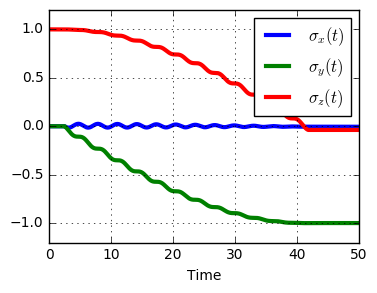

In [70]:
fig,ax = a.plot()
ax.set_title("")
ax.set_ylabel("")
ax.grid()


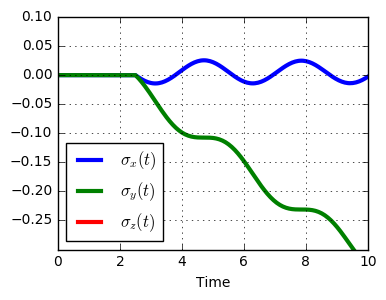

In [75]:
fig,ax = a.plot()
ax.set_title("")
ax.set_ylabel("")
ax.grid()
ax.set_xlim([0,10])
ax.set_ylim([-0.3,0.1])
ax.legend(bbox_to_anchor = [0,0],loc = "lower left")